# Panorama application

In [1]:
# Imports
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# Load images
img_11 = cv2.imread('../../data/panorama_1_1.jpg')
img_12 = cv2.imread('../../data/panorama_1_2.jpg')
img_21 = cv2.imread('../../data/panorama_2_1.jpg')
img_22 = cv2.imread('../../data/panorama_2_2.jpg')
img1 = img_11
img2 = img_12

In [3]:
# Convert images to grayscale
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

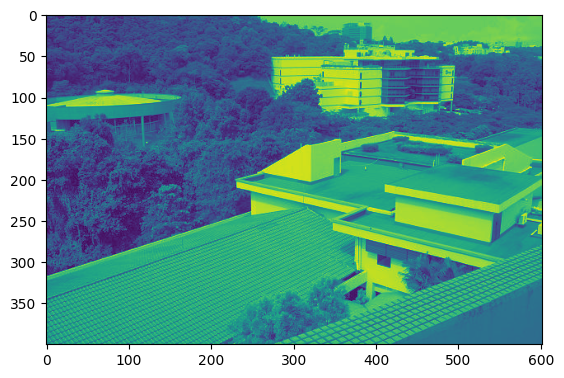

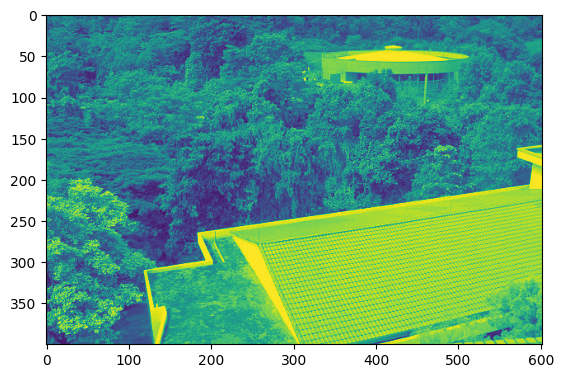


List of pixel coordinates in source image:
[[[  8.176267 157.77872 ]]

 [[ 16.969738 163.92577 ]]

 [[ 16.969738 163.92577 ]]

 [[ 19.18448  201.21701 ]]

 [[ 19.18448  201.21701 ]]]

List of pixel coordinates in destination image:
[[[357.27103  97.53997]]

 [[364.27634 104.15457]]

 [[364.27634 104.15457]]

 [[362.2862  139.4566 ]]

 [[362.2862  139.4566 ]]]

Homography matrix:
[[ 6.65213296e-01 -6.65360582e-02  3.66557087e+02]
 [ 1.96450031e-02  9.58687255e-01 -5.26036281e+01]
 [-5.95135405e-04  1.09716032e-04  1.00000000e+00]]


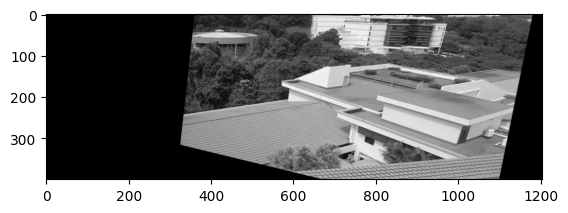

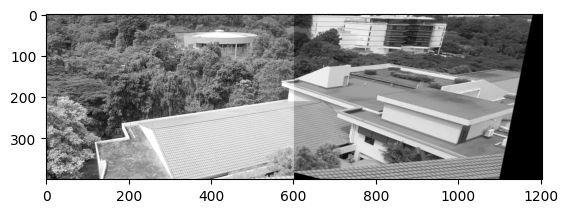

In [4]:

# Detect features and calculate feature descriptors
sift = cv2.SIFT_create() 
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

# Plot descriptors
plt.figure()
image_1_keys = img1.copy()
cv2.drawKeypoints(img1, kp1, image_1_keys)
plt.imshow(image_1_keys)

plt.figure()
image_2_keys = img2.copy()
cv2.drawKeypoints(img2, kp2, image_2_keys)
plt.imshow(image_2_keys)
plt.show()

# Create Brute Force Matcher
bf = cv2.BFMatcher()

# Select the top-2 matches of the descriptors
matches = np.array(bf.knnMatch(des1, des2, k=2))

# Select good matches
good = []
for m in matches:
    if m[0].distance < 0.5 * m[1].distance:
        good.append(m)
matches = np.asarray(good)

# Calculate the homography matrix of the 2 images using RANSAC
if len(matches[:, 0]) >= 4:
    
    # Get pixel coordinates p of the matched features in the source image
    src = []
    for m in matches[:, 0]:
        match_index = m.queryIdx
        pixel_coordinates_of_keypoint = kp1[match_index].pt
        src.append(pixel_coordinates_of_keypoint)
    src = np.float32(src).reshape(-1, 1, 2)
    print("\nList of pixel coordinates in source image:")
    print(src[0:5, :])

    # Get pixel coordinates p of the matched features in the destination image
    dst = []
    for m in matches[:, 0]:
        match_index = m.trainIdx
        pixel_coordinates_of_keypoint = kp2[match_index].pt
        dst.append(pixel_coordinates_of_keypoint)
    dst = np.float32(dst).reshape(-1, 1, 2)
    print("\nList of pixel coordinates in destination image:")
    print(dst[0:5, :])
    
    # Compute H using correspondences
    H, masked = cv2.findHomography(src, dst, cv2.RANSAC, 5.0)
    
    # Print matrix H
    print("\nHomography matrix:")
    print(H)
    
else:
    raise AssertionError('Can’t find enough keypoints.')

# Stitch the images by transforming the destination image with the homography matrix
dst = cv2.warpPerspective(img1, H, ((img1.shape[1] + img2.shape[1]), img2.shape[0]))  # Warped image
plt.imshow(dst, cmap='gray')
plt.show()

dst[0:img2.shape[0], 0:img2.shape[1]] = img2  # Stitched image
plt.imshow(dst, cmap='gray')
plt.show()
